## 1. 项目介绍

### 1.1 项目背景
本项目是我学习自然语言处理的第一个项目，运行环境是[百度飞桨平台](https://aistudio.baidu.com/aistudio/index)。

项目内容主要是使用关于[疫情期间微博评论数据集](https://aistudio.baidu.com/aistudio/datasetdetail/130719/0)，利用飞桨的 `PaddleNLP` 自然语言处理开发库，以及预训练模型 `ERNIE` 完成对情绪识别模型的训练，最后进行『面向对象』测试，效果还不错，大家有兴趣可以试试看😜。


### 1.2 数据集来源

本数据集来源是赛事[疫情期间网民情绪识别](https://www.datafountain.cn/competitions/423)，此处将数据集解压至本项目 `/work` 目录下。

数据集是依据与“新冠肺炎”相关的230个主题关键词进行数据采集，抓取了2020年1月1日—2020年2月20日期间共计100万条微博数据，并对其中10万条数据进行人工标注，标注分为三类，分别为：**1（积极），0（中性）和-1（消极）**。

> ✋需要注意的是：直接fork本项目的数据集是没有问题的，但是选择使用目前AI studio[同类加精数据集](https://aistudio.baidu.com/aistudio/datasetdetail/22724/0)中的 `train_ dataset.zip` 名字有空格，进行解压之前需要重命名将空格去除，或使用引号。

In [1]:
# # 将数据集解压到 /work 目录下(首次解压取消注释)
# !unzip -oq data/data130719/train_dataset.zip -d work/
# !unzip -oq data/data130719/test_dataset.zip -d work/

In [2]:
# 将提交数据集复制到 /work下
!cp data/data130719/submit_example.csv work/submit_example.csv

In [3]:
# 查看数据集所在目录结构
!tree work/ -a

work/
├── .ipynb_checkpoints
│   ├── nCov_10k_test-checkpoint.csv
│   ├── submit_example-checkpoint.csv
│   └── test-checkpoint.txt
├── nCoV_100k_train.labled.csv
├── nCov_10k_test.csv
├── nCoV_900k_train.unlabled.csv
├── submit_example.csv
├── test.txt
├── train.txt
└── valid.txt

1 directory, 10 files


### 1.3 数据集信息

* **训练数据集**文件名称：nCoV_100k_train.labled.csv
	包含100000条微博用户发布的微博内容, 具体字段如下：

  * 微博id，格式为整型。
  * 微博发布时间，格式为 `xx月xx日 xx:xx`。
  * 发布人账号，格式为字符串。
  * 微博中文内容，格式为字符串。
  * 微博图片，格式为url超链接，`[ ]`代表不含图片。
  * 微博视频，格式为url超链接，`[ ]`代表不含视频。
  * 情感倾向，取值为 `{1,0,-1}`。

* **测试数据集**文件名称：work/nCov_10k_test.csv

	包含10000条微博用户发布的微博内容，每条数据包括`'微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频'`。

## 2. 数据探索和预处理

由于数据集是使用 `GB2312` 编码，所以需要使用对其进行重新编码并保存。

原始数据集中存在解码错误，是微博一些特殊符号或标签引起，难以使用常规编码进行解码，在此对其进行忽略。

In [4]:
# # 对文件进行重新编码（仅首次解压文件后运行）
# def re_code(path):
#    with open(path, 'r', encoding='GB2312', errors='ignore') as f:
#        lines = f.readlines()
#    with open(path, 'w', encoding='utf-8') as fw:
#         fw.write(''.join(lines))

# re_code('work/nCoV_100k_train.labled.csv')
# re_code('work/nCov_10k_test.csv')

### 2.1 读取数据

使用 `pandas` 读取训练集和数据集的数据。

> ✋在飞桨平台运行时，若需要在绘制图像时使用中文，则需要进行设置，普通的设置 `plt.rcParams["font.sans-serif"]=["SimHei"]` 和 `plt.rcParams["axes.unicode_minus"]=False`并不能在此简单解决问题。若需要折腾👍，则可以参考[解决AI Studio中matplotlib汉字显示问题](https://aistudio.baidu.com/aistudio/projectdetail/390895)。
>
> 不过在 **AI Studio** 的一次升级中，**新增文泉驿中文字体**，官方😘给出具体用法参考[Ubuntu 中使用 matplotlib 画图如何正常显示中文](https://www.jianshu.com/p/7d4f88c62815)，也就是此处使用的方法。

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 设置中文字体
myfont = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')

import warnings
# 过滤报警信息
warnings.filterwarnings("ignore", category=Warning)

In [6]:
# 读取训练集和测试集数据
df_train = pd.read_csv('work/nCoV_100k_train.labled.csv')
df_test = pd.read_csv('work/nCov_10k_test.csv')

In [7]:
# 查看数据集信息
print(f"训练集的数据大小为{df_train.shape}")
print(f"测试集的数据大小为{df_test.shape}")
print(f"数据字段为{df_train.columns}")
print(f"数据字段为{df_test.columns}")

训练集的数据大小为(100000, 7)
测试集的数据大小为(10000, 6)
数据字段为Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频', '情感倾向'], dtype='object')
数据字段为Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频'], dtype='object')


In [8]:
# 简单查看一下数据
df_train.head(2).append(df_train.tail(2))

,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频,情感倾向
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
99998,4472950743017610,02月17日 13:40,医库,【新冠疫情最受关注的十一篇英文核心期刊论文全解析】本文整理了关于新型冠状病毒最受关注的十一篇...,[],[],1
99999,4472870103356260,02月17日 08:19,有度为王,"从蝙蝠携带的冠状病毒变异成2019-nCoV冠状病毒,怎样才能发生变异呢？有两种可能1.自然...",[],[],0


### 2.2 标签分布

对于训练集，用户情感已经进行了标注，并分为三类，分别是：**1（积极），0（中性）和-1（消极）**。

但是数据集中存在部分异常数据，将其删除。

进而绘制柱状图可以发现：大部分样本表现出中性情绪，其次是积极情绪，而消极情绪样本最小。

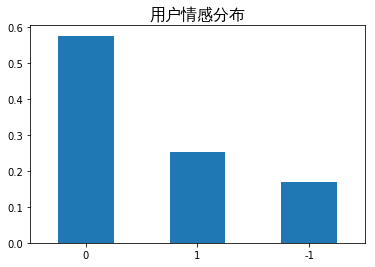

In [9]:
# 删除极少量（7条）异常数据，保留正常情感倾向标签
df_train = df_train[df_train['情感倾向'].map(lambda x: x == '1' or x == '-1' or x == '0')]
df_train.shape

df_train['情感倾向'].value_counts(normalize=True).plot.bar(rot=0)
plt.title("用户情感分布", fontproperties=myfont, fontsize=16)
plt.show()

### 2.3 文本长度

微博内容包括`微博中文内容、微博图片、微博视频`三部分，但对于我们来说，只关心用户发表的文本信息，所以在此对文本进行查看

可以发现：平均长度为`87`个字符，最大长度为`241`个字符，大部分文本长度处于在`150`个字符以下，呈**双峰分布**。

In [10]:
df_train.loc[:, '微博中文内容'] = df_train.loc[:, '微博中文内容'].astype(str)
text_length = df_train.loc[:, '微博中文内容'].map(lambda x: len(x))
text_length.name = '中文内容长度'

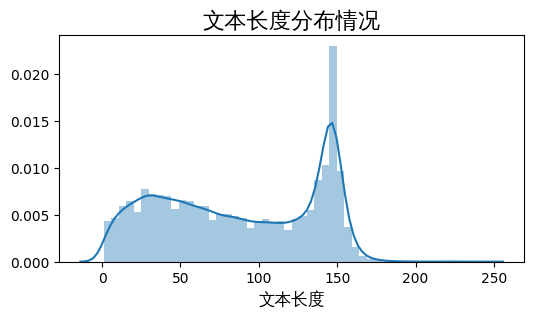

In [11]:
# 调节图像大小, 清晰度
plt.figure(figsize=(6,3), dpi=100)
# 绘制直方图
sns.distplot(text_length)
plt.title('文本长度分布情况', fontproperties=myfont, fontsize=16)
plt.xlabel('文本长度', fontproperties=myfont, fontsize=12)
plt.show()

In [12]:
text_length.describe()

count    99913.000000
mean        86.978661
std         49.521746
min          1.000000
25%         42.000000
50%         86.000000
75%        139.000000
max        241.000000
Name: 中文内容长度, dtype: float64

### 2.4 划分数据集

在原本数据集中存在很多不需要的字段，仅需要保留 `微博中文内容` 和 `微博中文内容` 即可。

并将提供的整个训练集划分为：训练集和验证集。并保存为txt文件

In [13]:
# 使用 train_test_split 自动划分训练集和验证集
from sklearn.model_selection import train_test_split

train_labled = df_train[['微博中文内容', '情感倾向']]
train, valid = train_test_split(train_labled, test_size=0.2, random_state=10086)
train.to_csv('work/train.txt', index=False, header=False, sep='\t')
valid.to_csv('work/valid.txt', index=False, header=False, sep='\t')

test = df_test[['微博中文内容']]
test.to_csv('work/test.txt', index=False, header=False, sep='\t')

### 2.5 使用load_dataset导入数据

为了保持数据和paddlenlp默认数据集一致， 使用 `paddlenlp.datasets.load_dataset` 从本地文件中导入数据。

需要自定义 `read_out` 方法来进行数据格式处理。

> ✋注意：但是由于后续在计算损失`loss = criterion(logits, labels)`的时候一直报一个`-1`的错误, 所以这里将用户情感标签修改为**2（积极），1（中性）和0（消极）**，但不影响模型。具体原因不是非常明白，若有大佬清楚，欢迎留言指点😘。

In [14]:
import paddle
import paddlenlp as ppnlp
from paddlenlp.datasets import load_dataset

def read_out(data_path):
    """
    使用自定义数据集本地加载，读取整理好的数据集
    """
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            line_stripped = line.strip().split('\t')
            if not line_stripped:
                break
            if len(line_stripped) == 2:
                text = line_stripped[0]
                tags = int(line_stripped[1]) + 1  # 使标签变成 0-消极， 1-中性， 2-积极
            else:
                text = line_stripped
                tags = []
            yield {"text": text, "label": tags}


# 分别根据自定义的读取方法，从文件中获得训练和验证数据
train_ds = load_dataset(read_out, data_path='work/train.txt', lazy=False)
dev_ds = load_dataset(read_out, data_path='work/valid.txt', lazy=False)

### 2.6 数据集测试

主要是测试加载数据的方法是否可行，并观察数据的格式等基本情况。

In [15]:
print('=============测试训练集=============')
for data in train_ds.data[:3]:
    print(data)

print('=============测试验证集=============')
for data in dev_ds.data[:3]:
    print(data)

=============测试训练集=============
{'text': '这几天做得最多的表情是，凶，生气，皱眉，面目狰狞，主要是显示出我的气势但好累呀晚上有两只狗没牵绳的，我和阿福先在草坪那里站着，突然后面就来声音把我吓着了，两个狗子其实看上去也挺漂亮可爱。就是一直追着阿福，阿福叫得厉害，我一直拉着阿福回家，本来阿福都平静下来了，结果其中?展开全文c', 'label': 1}
{'text': '#天天向上#哈哈哈哈哈哈哈天天向上太优秀了，云录制，期待啊?', 'label': 2}
{'text': '对于这次病毒战役，从目前的数据来看，致死率一直维持比较低的状态，湖北本身前期准备工作等不足导致病死率相对高点，但省外和国外，病死率一直控制在极低水平。02DYxHg03。外，近期白岩松邀请流行病学家吴尊友谈病死率的时候就给到这样的数据：经过7000多病例的分析,1,小于30岁的基本没有死亡。2,40至?展开全文c', 'label': 1}
=============测试验证集=============
{'text': '//@秦t墨://@贝勒王duki://@进击的熊爸爸:都是中国人//@Makerforce:不一样的中国。东北三省不分家，江苏十三太保各自为政充分体现了共和国的多样型', 'label': 2}
{'text': '#摩登兄弟武汉演唱会#??#元萸啻夯锇榱跤钅#??摩登兄弟摩登兄弟mdxd刘宇宁lyn棚主宁哥陪你的第二个跨年，这一年你收获了好多成绩，演唱会，专辑，电视剧，各个活动，真的特别棒，2020年继续加油努力，我们还会陪在你的身边一直支持你。@MD_摩登兄弟?', 'label': 2}
{'text': '早日团员！#万众一心打赢疫情防控阻击战##防控疫情西藏在行动#', 'label': 2}


## 3. 模型介绍

训练模型使用的是 `ERNIE`，是百度开创性提出的基于知识增强的持续学习**语义理解框架**，该框架将大数据预训练与多源丰富知识相结合，通过持续学习技术，不断吸收海量文本数据中词汇、结构、语义等方面的知识，实现模型效果不断进化，详细介绍可参考[持续学习语义理解框架ERNIE](https://aistudio.baidu.com/aistudio/projectdetail/3562850)。

### 3.1 Transformer

`ERNIE` 使用 `Transformer` 作为其语义框架。

将语句中所有的词传入到 `Transformer` 模型中，通过一个 `self-attention` 机制计算出在该语句中各个词之间的关系，表现出哪些词的权重更大，再进行类似归一化和求和的操作，并通过前馈神经网络多层表示，最后得到这个词的新的表示。

![Transformer模型](image/Transformer模型.png)

### 3.2 ERNIE 模型

`BERT` 全称是 **E**nhanced **R**epresentation through k**N**owledge **I**nt**E**gration 『基于知识融合(Knowledge Masking)的新一代语义表示模型』，模型是基于`Transformer` 模型产生的，其预训练任务有两个：

* 一个是类似完形填空任务，通过 `Mask` 掩盖部分字，再进行预测得到该语句，通过这个过程就学习了字与字之间的规律；
* 另一个是上下文语句的预测，学习句子之间的语句关系。

但是模型难以学到词、短语和实体完整的语义关系。

相较于 `BERT` 学习原始语言信号，`ERNIE 1.0` 提出了一个知识融合的方法，通过对词、短语和实体的**完整**的语义关系进行掩码和预测。


## 4. 训练模型

首先确保安装了PaddleNLP。

In [16]:
# 安装PaddleNLP
!pip install --upgrade paddlenlp

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


### 4.1 加载模型

由于预训练模型 `ERNIE` 对中文数据的处理是以字为单位，所以需要将训练数据转化为相应的数据形式，以此来匹配模型的输入。

在 `PaddleNLP` 中，对于很多预训练模型都内置了 `tokenizer` 来实现对输入的自然语句进行 `token` 化，按照字粒度对句子进行切分，只需要指定想要使用的模型名字作为参数即可。

In [17]:
# 设置想要使用模型的名称
MODEL_NAME = "ernie-1.0"

# 加载转化数字格式的工具 tokenizer
tokenizer = ppnlp.transformers.ErnieTokenizer.from_pretrained(MODEL_NAME)
# 加载模型
model = ppnlp.transformers.ErnieForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=len(['-1','0','1']))

[2022-03-05 16:29:22,776] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-1.0/vocab.txt
[2022-03-05 16:29:22,791] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-1.0/ernie_v1_chn_base.pdparams
W0305 16:29:22.794826 11862 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0305 16:29:22.800236 11862 device_context.cc:465] device: 0, cuDNN Version: 7.6.


### 4.2 构建加载器 DataLoader

* `paddlenlp.data.Stack`：用于堆叠N个具有相同shape的输入数据来**构建一个batch**。
* `paddlenlp.data.Pad`：用于堆叠N个输入数据来构建一个batch，每个输入数据将会被**padding到**N个输入数据中**最大的长度**。
* `paddlenlp.data.Tuple`：用于将多个batchify函数**包装**在一起，返回tuple类型。

In [18]:
from functools import partial
from paddlenlp.data import Stack, Tuple, Pad
from utils import  convert_example, create_dataloader

# 模型运行批处理大小
batch_size = 256
# 样本最大长度
max_seq_length = 128

# 定义转换数据形式的方法
trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

# 指定如何合并样本，组一个batch
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # segment
    Stack(dtype="int64")  # label
): [data for data in fn(samples)]

# 训练集数据加载器
train_data_loader = create_dataloader(
    train_ds,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)
# 验证集数据加载器
dev_data_loader = create_dataloader(
    dev_ds,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

### 4.3 构建优化器、选择损失函数和度量指标

* 学习率：Warmup 是一种学习率预热方法，在训练开始时先选择较小的学习率，训练一定程度后，再修改为预先设置的学习率训练。而 Decay 是学习率衰减方法，它指定在训练到一定 epochs 或者 steps 后，按照线性或者余弦函数等方式，将学习率降低至指定值。此处使用 `LinearDecayWithWarmup`，学习率会遵循**从小到大，再减小**的规律。
* 优化器：就是在深度学习反向传播过程中，指引损失函数（目标函数）的各个参数往正确的方向更新合适的大小，使得更新后的各个参数让损失函数（目标函数）值不断逼近全局最小。 这里选择使用 `AdamW` 优化算法。
* 损失函数：此处选择交叉熵损失函数 `CrossEntropyLoss`，交叉熵的大小表示两个概率分布之间的差异，可以通过最小化交叉熵来得到目标概率分布的近似分布。
* 度量指标：选择准确率 `Accuracy`。

In [19]:
from paddlenlp.transformers import LinearDecayWithWarmup

# 训练过程中的最大学习率
learning_rate = 5e-5 
# 训练轮次
epochs = 5
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01

num_training_steps = len(train_data_loader) * epochs
# 学习率调整策略
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)
# 优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()  # 交叉熵损失函数
metric = paddle.metric.Accuracy()  # 准确率

### 4.4 模型训练与评估

在每个训练模型训练步骤：

1. 从 `dataloader` 中取出一个`batch data`；
2. 将 `batch data` 作为输入传入 `model`，做前向计算；
3. 将前向计算结果传给损失函数，计算 `loss`；将前向计算结果传给评价方法，计算评价指标；
4. loss反向回传，更新梯度；
5. 重复以上步骤。

每训练一个 epoch 时，程序将会评估一次，评估当前模型训练的效果。

In [20]:
# model文件夹用于保存训练模型
!mkdir /home/aistudio/model

mkdir: 无法创建目录"/home/aistudio/model": 文件已存在


In [21]:
import paddle.nn.functional as F
from utils import evaluate

global_step = 0
all_loss = []
all_acc = []
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()
        all_loss.append(loss)
        all_acc.append(acc)

        global_step += 1
        if global_step % 10 == 0 :
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
    evaluate(model, criterion, metric, dev_data_loader)

model.save_pretrained('/home/aistudio/model')
tokenizer.save_pretrained('/home/aistudio/model')

global step 10, epoch: 1, batch: 9, loss: 1.72641, acc: 0.17344
global step 20, epoch: 1, batch: 19, loss: 1.44896, acc: 0.17266
global step 30, epoch: 1, batch: 29, loss: 1.38964, acc: 0.18958
global step 40, epoch: 1, batch: 39, loss: 1.08722, acc: 0.20977
global step 50, epoch: 1, batch: 49, loss: 1.00216, acc: 0.25938
global step 60, epoch: 1, batch: 59, loss: 0.92373, acc: 0.30885
global step 70, epoch: 1, batch: 69, loss: 0.89821, acc: 0.35067
global step 80, epoch: 1, batch: 79, loss: 0.92912, acc: 0.37969
global step 90, epoch: 1, batch: 89, loss: 0.81948, acc: 0.40729
global step 100, epoch: 1, batch: 99, loss: 0.72633, acc: 0.42750
global step 110, epoch: 1, batch: 109, loss: 0.82914, acc: 0.44858
global step 120, epoch: 1, batch: 119, loss: 0.76767, acc: 0.46641
global step 130, epoch: 1, batch: 129, loss: 0.70897, acc: 0.48221
global step 140, epoch: 1, batch: 139, loss: 0.77717, acc: 0.49967
global step 150, epoch: 1, batch: 149, loss: 0.84634, acc: 0.51385
global step 160

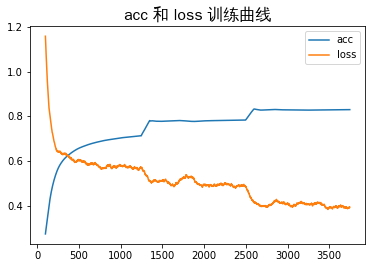

In [26]:
# 绘制模型训练过程曲线
accArr = pd.Series(all_acc,name='acc')
lossArr = pd.Series(all_loss, name='loss')

accRoll = accArr.rolling(window=100).mean()
lossRoll = lossArr.rolling(window=100).mean()  # 使用滑动窗口使得数据平滑，观察趋势
accRoll.plot()
lossRoll.plot()

plt.legend()
plt.title("acc 和 loss 训练曲线", fontproperties=myfont, fontsize=16)
plt.show()

## 5. 模型预测

### 5.1 赛题数据预测

对测试数据进行预测，并上传比赛平台。并绘制测试集预测结果，用户情感分布情况，与训练集大致上类似。

In [27]:
from utils import predict

# 读取测试集数据
test = pd.read_csv('work/test.txt', names=['text'] , sep='\t', dtype=str)
test = test.fillna(' ')  # 填补空值
data = test.to_dict(orient='record')

label_map = {0: '-1', 1: '0', 2: '1'}  # 标记map

# 模型预测
pred_label = predict(model, data, tokenizer, label_map, batch_size=batch_size)

# 写入结果
submit = pd.read_csv('work/submit_example.csv')
submit['y'] = pd.DataFrame(pred_label)
submit.to_csv('work/submit_example.csv',index=False)

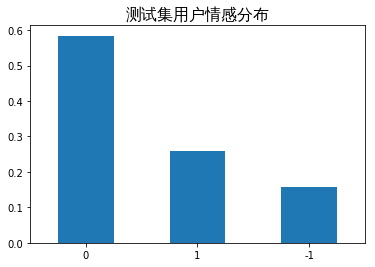

In [28]:
# 绘制测试集用户情感分布
submit['y'].value_counts(normalize=True).plot.bar(rot=0)
plt.title("测试集用户情感分布", fontproperties=myfont, fontsize=16)
plt.show()

### 5.2 🙊『面向对象』测试。

脱离语境问题不大，但是结合聊天语境就有些欠缺了，毕竟只是一个短文本三分类，而且并不是相关训练集训练。

In [29]:
from utils import predict

data = [
    {"text":'yyl是个大笨蛋'},
    {"text":'yyl很可爱'},
    {"text":'yyl是一名幼稚园小朋友'},
    {"text":'就你还能分析出我的情感？'},
    {"text":'我不信我不信'},
    {"text":'预测的很准，下次不要预测了'},
]

label_map = {0: 'negative', 1: 'neutral ', 2: 'positive'} 

results = predict(model, data, tokenizer, label_map, batch_size=batch_size)
for idx, text in enumerate(data):
    print(f"Lable: {results[idx]} \t {text['text']}")

Lable: negative 	 yyl是个大笨蛋
Lable: positive 	 yyl很可爱
Lable: neutral  	 yyl是一名幼稚园小朋友
Lable: negative 	 就你还能分析出我的情感？
Lable: negative 	 我不信我不信
Lable: neutral  	 预测的很准，下次不要预测了


## 6. 总结与升华

本次项目使用疫情期间在微博平台上网民的言论及其情绪是否积极的标签来训练模型，从而使得可以对疫情期间网民情绪有大体上的了解，从而可以进行正确的引导。

项目中使用的是`ERNIE` 模型，很多的内容都已经封装过了，学习时只要知道基本的原理和接口就可以快速实现一个情感分类的模型，最后提交的模型得分是0.703，大概在400名左右，如果进一步进行细致的调参可能会有更好的效果。

总的来说该项目使我第一次认识到自然语言处理的一些处理方法和大致流程，希望之后能在NLP领域更深入的学习。

## 7. 个人总结

我目前感兴趣的方向是自然语言处理，希望有兴趣的伙伴多多交流。

* [Github](https://github.com/Gipbear)
* [CSDN](https://blog.csdn.net/weixin_49689323)
* [个人Blog](https://gipbear.github.io/)
